In [8]:
import numpy as np
import random
from collections import defaultdict

def train_q_learning(params):
    # Unpack parameters
    episodes = params.get('episodes', 10000)
    decay_epsilon = params.get('decay_epsilon', True)
    gamma = params.get('gamma', 0.9)
    alpha = params.get('alpha', 0.5)
    epsilon_start = params.get('epsilon_start', 1.0)
    epsilon_end = params.get('epsilon_end', 0.05)
    decay_rate = params.get('decay_rate', 0.0005)
    living_reward = params.get('living_reward', -0.1)
    log_every = params.get('log_every', 100)

    # Grid-world setup
    cols, rows = 4, 3
    start_state = (1, 1)
    terminals = {(4, 3): +1, (4, 2): -1}
    walls = {(2, 2)}
    actions = ['up', 'down', 'left', 'right']
    action_vectors = {
        'up': (0, 1), 'down': (0, -1),
        'left': (-1, 0), 'right': (1, 0)
    }

    def get_possible_moves(action):
        if action == 'up':
            return [('up', 0.8), ('left', 0.1), ('right', 0.1)]
        elif action == 'down':
            return [('down', 0.8), ('left', 0.1), ('right', 0.1)]
        elif action == 'left':
            return [('left', 0.8), ('up', 0.1), ('down', 0.1)]
        elif action == 'right':
            return [('right', 0.8), ('up', 0.1), ('down', 0.1)]

    def move(state, action):
        moves = get_possible_moves(action)
        chosen = random.choices(moves, weights=[p for _, p in moves])[0][0]
        dc, dr = action_vectors[chosen]
        nc, nr = state[0] + dc, state[1] + dr
        if (nc, nr) in walls or not (1 <= nc <= cols and 1 <= nr <= rows):
            return state
        return (nc, nr)

    Q = defaultdict(lambda: {a: 0 for a in actions})
    episode_rewards = []

    for ep in range(episodes):
        epsilon = (
            epsilon_end + (epsilon_start - epsilon_end) * np.exp(-decay_rate * ep)
            if decay_epsilon else epsilon_start
        )
        state = start_state
        total_reward = 0

        while state not in terminals:
            action = (
                random.choice(actions)
                if random.random() < epsilon
                else max(Q[state], key=Q[state].get)
            )
            next_state = move(state, action)
            reward = terminals.get(next_state, living_reward)
            total_reward += reward

            best_next = max(Q[next_state].values()) if next_state not in terminals else 0
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])
            state = next_state

        episode_rewards.append(total_reward)

        if log_every and ep % log_every == 0:
            print(f"Episode {ep:>5}: Total Reward = {total_reward:.2f} | Epsilon = {epsilon:.3f}")

    return Q, episode_rewards

In [9]:
NUM_EPISODES=10000

params = {
    'episodes': NUM_EPISODES,
    'decay_epsilon': True,
    'gamma': 0.95,
    'alpha': 0.4,
    'epsilon_start': 1.0,
    'epsilon_end': 0.05,
    'decay_rate': 0.001,
    'living_reward': -0.1,
    'log_every': 200,
    'optimal_return': 0.4  # Assumed optimal return for the terminal state
}

Q, rewards = train_q_learning(params)


Episode     0: Total Reward = -1.20 | Epsilon = 1.000
Episode   200: Total Reward = -1.80 | Epsilon = 0.828
Episode   400: Total Reward = -0.10 | Epsilon = 0.687
Episode   600: Total Reward = -0.90 | Epsilon = 0.571
Episode   800: Total Reward = 0.20 | Epsilon = 0.477
Episode  1000: Total Reward = -0.60 | Epsilon = 0.399
Episode  1200: Total Reward = -0.20 | Epsilon = 0.336
Episode  1400: Total Reward = -0.70 | Epsilon = 0.284
Episode  1600: Total Reward = -0.80 | Epsilon = 0.242
Episode  1800: Total Reward = -0.10 | Epsilon = 0.207
Episode  2000: Total Reward = 0.50 | Epsilon = 0.179
Episode  2200: Total Reward = -0.70 | Epsilon = 0.155
Episode  2400: Total Reward = -0.50 | Epsilon = 0.136
Episode  2600: Total Reward = 0.60 | Epsilon = 0.121
Episode  2800: Total Reward = 0.50 | Epsilon = 0.108
Episode  3000: Total Reward = 0.60 | Epsilon = 0.097
Episode  3200: Total Reward = 0.30 | Epsilon = 0.089
Episode  3400: Total Reward = 0.50 | Epsilon = 0.082
Episode  3600: Total Reward = 0.60 

# Average Reward vs Episode

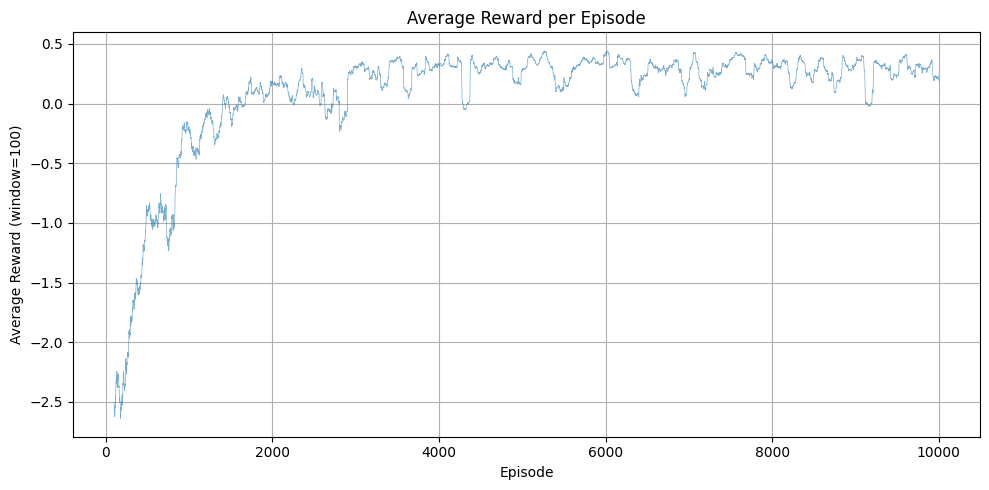

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Compute moving average
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot
window = 100
avg_rewards = moving_average(rewards, window)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(avg_rewards)) + window, avg_rewards, alpha=0.6, linewidth=0.5)
plt.xlabel("Episode")
plt.ylabel(f"Average Reward (window={window})")
plt.title("Average Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.show()


# Raw Reward per Episode

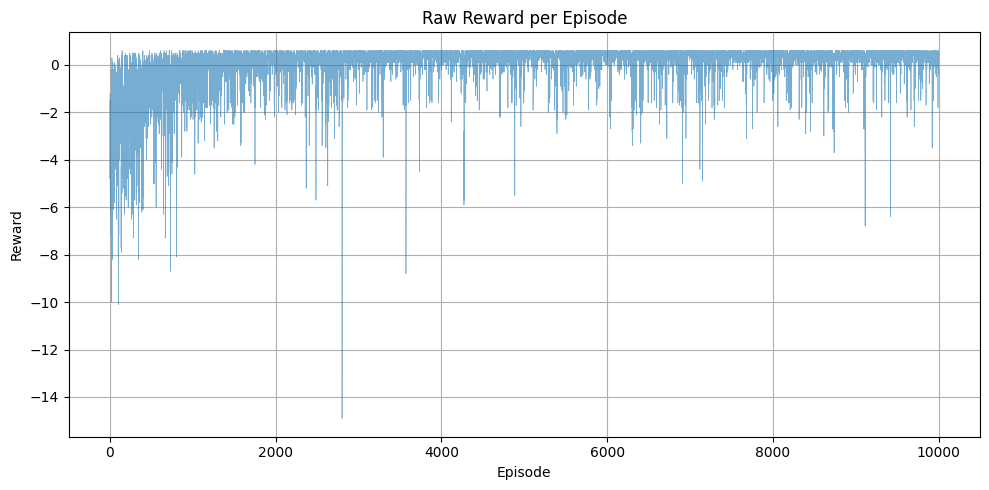

In [11]:
# Re-import necessary libraries after kernel reset
import matplotlib.pyplot as plt
import numpy as np

# Plot raw episode rewards
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPISODES + 1), rewards, alpha=0.6, linewidth=0.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Raw Reward per Episode")
plt.grid(True)
plt.tight_layout()
plt.show()


# Average regret per episode

> an agent's **regret** is defined as the cumulative difference between the optimal possible return and the reward actually obtained at each episode.

The `optimal_return` is the **maximum expected total reward** the agent could get in an episode if it followed the **best possible policy**—from the start state to a terminal state, with no mistakes or delays.

### In the grid-world:

* Start at (1,1)
* Goal at (4,3) gives reward +1
* Each step has a **living penalty** (e.g., –0.1)

Let’s say the optimal path takes 6 steps:

* The reward for that episode would be:

  $$
  +1 + 6 \times (-0.1) = +0.4
  $$

So:

```python
optimal_return = 0.4
```

This value is used to measure **regret**:

> How much reward did the agent fail to collect compared to the best-case scenario?

The agent's regret allows us to evaluate learning progress **independently** of randomness in the environment, by comparing to a fixed target.

In [12]:
def plot_regret(episode_rewards, optimal_return):
    import matplotlib.pyplot as plt
    import numpy as np

    episode_rewards = np.array(episode_rewards)
    regret = np.cumsum(optimal_return - episode_rewards)
    avg_regret = regret / np.arange(1, len(regret) + 1)

    plt.figure(figsize=(12, 5))

    # Cumulative Regret
    plt.subplot(1, 2, 1)
    plt.plot(regret, label='Cumulative Regret')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Regret")
    plt.title("Cumulative Regret Over Episodes")
    plt.grid(True)
    plt.legend()

    # Average Regret
    plt.subplot(1, 2, 2)
    plt.plot(avg_regret, label='Average Regret', color='orange')
    plt.xlabel("Episode")
    plt.ylabel("Average Regret")
    plt.title("Average Regret Per Episode")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


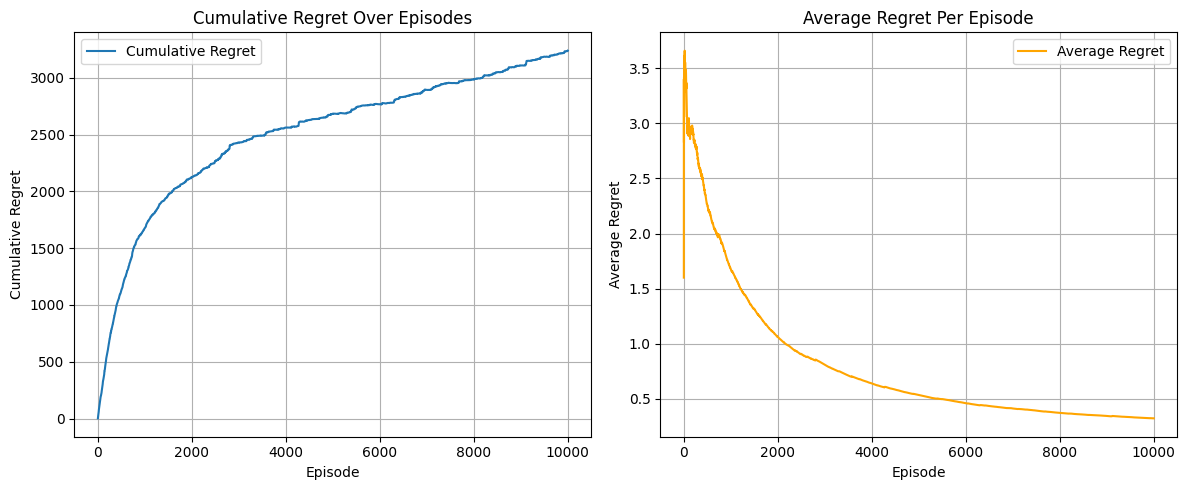

In [13]:
plot_regret(rewards, params['optimal_return'])

# Plot Q-values and learned policy

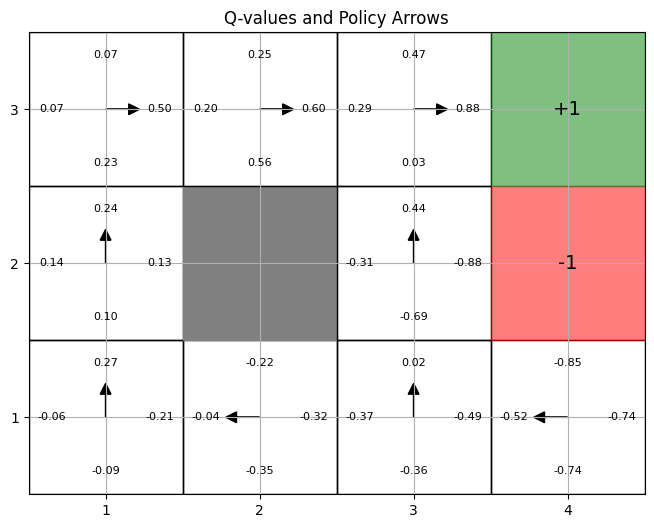

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Q-values and policy
fig, ax = plt.subplots(figsize=(8, 6))
cols, rows = 4, 3
walls = {(2, 2)}
terminals = {(4, 3): +1, (4, 2): -1}
actions = ['up', 'down', 'left', 'right']

for c in range(1, cols + 1):
    for r in range(1, rows + 1):
        state = (c, r)
        if state in walls:
            ax.add_patch(plt.Rectangle((c - 1, r - 1), 1, 1, color='gray'))
            continue
        if state in terminals:
            color = 'green' if terminals[state] > 0 else 'red'
            ax.add_patch(plt.Rectangle((c - 1, r - 1), 1, 1, color=color, alpha=0.5))
            ax.text(c - 0.5, r - 0.5, f"{terminals[state]:+.0f}", ha='center', va='center', fontsize=14)
            continue
        ax.add_patch(plt.Rectangle((c - 1, r - 1), 1, 1, edgecolor='black', fill=None))
        q_vals = Q.get(state, {a: 0.0 for a in actions})
        offsets = {
            'up': (0.5, 0.85), 'down': (0.5, 0.15),
            'left': (0.15, 0.5), 'right': (0.85, 0.5)
        }
        for action, (dx, dy) in offsets.items():
            val = q_vals.get(action, 0.0)
            ax.text(c - 1 + dx, r - 1 + dy, f"{val:.2f}", ha='center', va='center', fontsize=8)
        best_action = max(q_vals, key=q_vals.get)
        cx, cy = c - 0.5, r - 0.5
        arrow_dx, arrow_dy = {
            'up': (0, 0.15), 'down': (0, -0.15),
            'left': (-0.15, 0), 'right': (0.15, 0)
        }[best_action]
        ax.arrow(cx, cy, arrow_dx, arrow_dy, head_width=0.07, head_length=0.07, color='black')

ax.set_xticks(np.arange(cols) + 0.5)
ax.set_yticks(np.arange(rows) + 0.5)
ax.set_xticklabels([str(c) for c in range(1, cols + 1)])
ax.set_yticklabels([str(r) for r in range(1, rows + 1)])
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.grid(True)
ax.set_title("Q-values and Policy Arrows")
plt.gca().set_aspect('equal')
plt.show()
